In [0]:
import tensorflow as tf
tf.enable_eager_execution()

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import csv
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Download the colors dataset
if not os.path.exists('colors.csv'):
  !curl -O 'https://raw.githubusercontent.com/random-forests/datasets/master/colors.csv'
!head colors.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  323k  100  323k    0     0  57959      0  0:00:05  0:00:05 --:--:-- 78776
name,red,green,blue
parakeet,174,182,87
saddle brown,88,52,1
cucumber crush,222,237,215
pool blue,134,194,201
distance,98,110,130
light urple,179,111,246
east side,172,145,206
florida seashells,250,228,199
paris,145,167,189


In [3]:
# Read the data
colors_rgb = []
csv_reader = csv.reader(open('colors.csv'), delimiter=',')
next(csv_reader) # Remove the header
for row in csv_reader:
    name, r, g, b = row[0].lower().strip(), float(row[1]) / 255.0, float(row[2]) / 255.0, float(row[3]) / 255.0
    colors_rgb.append((name, r, g, b))
print(len(colors_rgb), 'colors downloaded')
print('For example', colors_rgb[0])

14157 colors downloaded
For example ('parakeet', 0.6823529411764706, 0.7137254901960784, 0.3411764705882353)


In [0]:
names = [item[0] for item in colors_rgb]

In [0]:
names

In [0]:
maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
# padding is at the beginning of the sentences, but could change the settlment 
# by changing the padding = 'post'
padded_names = pad_sequences(tokenized, maxlen=maxlen)
padded_names = padded_names.astype('float32')

In [8]:
padded_names


array([[ 0.,  0.,  0., ...,  1.,  1.,  9.],
       [ 0.,  0.,  0., ...,  8., 20.,  6.],
       [ 0.,  0.,  0., ..., 12., 10., 16.],
       ...,
       [ 0.,  0.,  0., ...,  8.,  6.,  1.],
       [ 0.,  0.,  0., ...,  1.,  1.,  6.],
       [ 0.,  0.,  0., ...,  5., 11.,  1.]], dtype=float32)

In [0]:
## colors_rgb is the list containing the color name and the values of all
## these colors
r = [item[1] for item in colors_rgb]
g = [item[2] for item in colors_rgb]
b = [item[3] for item in colors_rgb]
targets = np.column_stack([r, g, b])

In [12]:
## targets is the combination of these three color values
targets

array([[0.68235294, 0.71372549, 0.34117647],
       [0.34509804, 0.20392157, 0.00392157],
       [0.87058824, 0.92941176, 0.84313725],
       ...,
       [0.64705882, 0.70588235, 0.66666667],
       [0.03529412, 0.21176471, 0.14117647],
       [0.6745098 , 0.43921569, 0.41960784]])

In [70]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((1, maxlen), input_shape=(maxlen,)))
# FIX ME
# This simple model will work
# but won't make useful predictions
# return_sequences = True: 1. to stack the RNN celle, 
# 2. generate the classification results in each step
# default is to set the return_sequences = False, which 
# only return the hidden sequence in the last state
model.add(tf.keras.layers.LSTM(128, return_sequences=True,kernel_initializer='random_normal', bias_initializer='random_normal'))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='sigmoid'))
model.compile(optimizer=tf.train.AdamOptimizer(), loss='mse', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_16 (Reshape)         (None, 1, 25)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 1, 128)            78848     
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 195       
Total params: 218,883
Trainable params: 218,883
Non-trainable params: 0
_________________________________________________________________


In [71]:
# we're going to massively overfit on the training
# data... that's fine for this experiment
history = model.fit(padded_names, targets, epochs=5, validation_split=0.1)

Epoch 1/5
399/399 [==============================] - 33s 84ms/step - loss: 0.0630 - acc: 0.6186 - val_loss: 0.0640 - val_acc: 0.6335
Epoch 2/5
399/399 [==============================] - 33s 84ms/step - loss: 0.0595 - acc: 0.6541 - val_loss: 0.0637 - val_acc: 0.6448
Epoch 3/5
399/399 [==============================] - 34s 85ms/step - loss: 0.0576 - acc: 0.6637 - val_loss: 0.0619 - val_acc: 0.6653
Epoch 4/5
399/399 [==============================] - 33s 84ms/step - loss: 0.0560 - acc: 0.6669 - val_loss: 0.0592 - val_acc: 0.6547
Epoch 5/5
399/399 [==============================] - 34s 84ms/step - loss: 0.0547 - acc: 0.6668 - val_loss: 0.0605 - val_acc: 0.6716


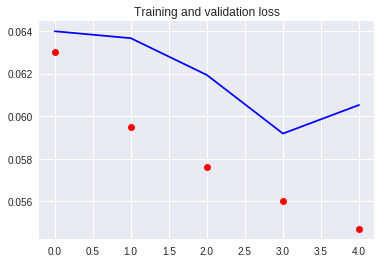

In [72]:
# let's see how badly we've overfit
# (don't worry about it for this assignment)
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'bo',c = 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.show()

In [0]:
# plots a color image
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [0]:
def scale(n):
    return int(n * 255)

In [0]:
def predict(name):
    tokenized = t.texts_to_sequences([name])
    padded = pad_sequences(tokenized, maxlen=maxlen)
    padded = padded.astype('float32')
    pred = model.predict(np.array(padded))[0]
    # Check the shapes here if you run into trouble with the next 
    # method after adding your RNN
    print(pred)
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

[0.34204087 0.5440223  0.7384577 ]
light blue, R,G,B: 87 138 188


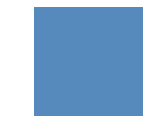

[0.37649423 0.49382678 0.6086016 ]
blue, R,G,B: 96 125 155


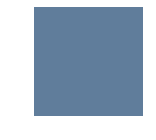

[0.36406985 0.46270952 0.5931054 ]
dark blue, R,G,B: 92 117 151


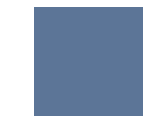

In [75]:
# some "test" data
predict("light blue")
predict("blue")
predict("dark blue")